In [1]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("Loading necessary libraries...")
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import cv2

print("Defining functions...")

# Function to extract features from images using SIFT or SURF
def extract_features(image_paths, method):
    descriptors = []
    for path in image_paths:
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if method == 'SIFT':
            feature_extractor = cv2.SIFT_create()
        elif method == 'SURF':
            feature_extractor = cv2.xfeatures2d.SURF_create()
        else:
            raise ValueError("Invalid feature extraction method. Choose either 'SIFT' or 'SURF'.")
        kp, des = feature_extractor.detectAndCompute(gray, None)
        if des is not None:
            descriptors.extend(des)
    return np.array(descriptors)

# Function to get image paths
def get_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

# Function to perform KMeans clustering
def perform_kmeans(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(features)
    return kmeans

Loading necessary libraries...
Defining functions...


In [5]:
print("Loading image paths...")
# Paths to bike and horse images
bike_directory = "/content/Bike-vs-Horse-classification/Dataset/Bikes"
horse_directory = "/content/Bike-vs-Horse-classification/Dataset/Horses"

# Extract paths to images
bike_paths = get_image_paths(bike_directory)
horse_paths = get_image_paths(horse_directory)

method = input("Enter feature extraction method (SIFT or SURF): ")

Loading image paths...
Enter feature extraction method (SIFT or SURF): SIFT


In [6]:
print(f"Extracting features using {method}...")
# Extract features
if method == 'SIFT':
    bike_features = extract_features(bike_paths, method='SIFT')
    horse_features = extract_features(horse_paths, method='SIFT')
elif method == 'SURF':
    bike_features = extract_features(bike_paths, method='SURF')
    horse_features = extract_features(horse_paths, method='SURF')
else:
    raise ValueError("Invalid feature extraction method. Choose either 'SIFT' or 'SURF'.")

print("Combining features...")
# Combine features
all_features = np.vstack((bike_features, horse_features))

Extracting features using SIFT...
Combining features...


In [10]:
# Elbow method

'''
Run this to get optimal cluster

this part took around 8 hrs to execute so commented it
'''

# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# distortions = []
# # Calculate distortions for different numbers of clusters from 1 TO 150
# for i in range(1, 151):
#   print(i)
#   kmeans = KMeans(n_clusters=i)
#   kmeans.fit(all_features)
#   distortions.append(kmeans.inertia_)
#   # Plot the elbow method graph
# plt.plot(range(1, 151), distortions, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.title('Elbow Method for Optimal K')
# plt.show()

'\nRun this to get optimal cluster\n\nthis part took around 8 hrs to execute so commented it\n'

In [11]:
print("Constructing image representations...")
# Construct image representations
num_clusters = int(input("Enter the number of clusters: "))
kmeans = perform_kmeans(all_features, num_clusters)

Constructing image representations...
Enter the number of clusters: 100


In [12]:
X_train = []
y_train = []
for paths, label in [(bike_paths, 0), (horse_paths, 1)]:
    for path in paths:
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if method == 'SIFT':
            kp, des = cv2.SIFT_create().detectAndCompute(gray, None)
        elif method == 'SURF':
            kp, des = cv2.xfeatures2d.SURF_create().detectAndCompute(gray, None)
        else:
            raise ValueError("Invalid feature extraction method. Choose either 'SIFT' or 'SURF'.")
        if des is not None:
            hist = np.zeros(num_clusters)
            labels = kmeans.predict(des)
            for l in labels:
                hist[l] += 1
            X_train.append(hist)
            y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

print("KMeans clustering completed.")

KMeans clustering completed.


In [23]:
print("Splitting data into train and test sets...")
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Splitting data into train and test sets...


In [24]:
print("Training SVM classifier...")
# Train SVM classifier
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

print("Evaluating classifier...")
# Evaluate classifier
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Training SVM classifier...
Evaluating classifier...
Accuracy: 0.9473684210526315


Printing classification report...
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        11

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19

Printing confusion matrix...


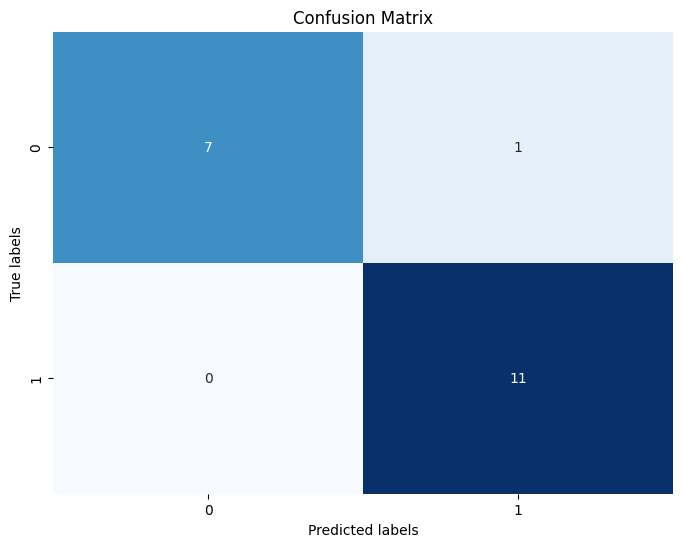

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Printing classification report...")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Printing confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
print("Training KNN classifier...")
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("Evaluating KNN classifier...")
# Evaluate KNN classifier
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("Training Logistic Regression classifier...")
# Train Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

print("Evaluating Logistic Regression classifier...")
# Evaluate Logistic Regression classifier
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)


Training KNN classifier...
Evaluating KNN classifier...
KNN Accuracy: 0.8421052631578947
Training Logistic Regression classifier...
Evaluating Logistic Regression classifier...
Logistic Regression Accuracy: 0.8947368421052632


In [28]:
def image_representation(image_path, kmeans, num_clusters, method):
    # Extract features from the new image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if method == 'SIFT':
        kp, des = cv2.SIFT_create().detectAndCompute(gray, None)
    elif method == 'SURF':
        kp, des = cv2.xfeatures2d.SURF_create().detectAndCompute(gray, None)
    else:
        raise ValueError("Invalid feature extraction method. Choose either 'SIFT' or 'SURF'.")
    if des is not None:
        hist = np.zeros(num_clusters)
        labels = kmeans.predict(des)
        for l in labels:
            hist[l] += 1
    return hist.reshape(1, -1)

Representing the new image using Bag-of-Visual-Words...
Predicting the class of the new image...


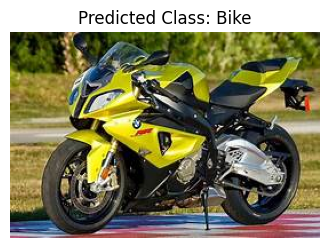

In [30]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
new_image_path = "/content/th.jpg"
new_image = cv2.imread(new_image_path)

print("Representing the new image using Bag-of-Visual-Words...")
# Represent the new image using Bag-of-Visual-Words
new_image_representation = image_representation(new_image_path, kmeans, num_clusters, method)

print("Predicting the class of the new image...")
# Predict the class of the new image using the trained SVM classifier
predicted_class = svm.predict(new_image_representation)
class_names = ['Bike', 'Horse']


plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicted Class: " + class_names[predicted_class[0]])
plt.show()

